## Dependencies

In [1]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt
import openpyxl
import plotly.graph_objs as go

In [2]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data
parameters=InputParameter('data/Parameters.xlsx')

def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data_Standalone.xlsx')

start = '2018-09-01 00:00:00'
end = '2019-08-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)

#res1, res2, sol = split_data('data/Modified_Data_inflow.csv')
#res1_inflow = []
#res2_inflow = []

#for i in range(2018,2022+1):
#    res1_inflow.append(res1[i])
#    res2_inflow.append(res2[i])

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.007)

rationing_cost = max(market_prices_h.values())

## Solving forward

In [3]:
## Contstraints and constants
constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': rationing_cost, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3}}

# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j):
    return model.v0[i]

def head_bounds(model,i,j):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j):
    return (model.S_min[i], model.S_max[i])

def inflow1_scenario(model, i, j):
    if i == 'Hydro1':
        return model.inflow[i, j] == inflow1[j]
    elif i == 'Hydro2':
        return model.inflow[i, j] == inflow2[j]
    
# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j] == model.L[j] - (model.r[j])

# + model.m['Buy',j]

def power_rule(model,i, j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j] == model.p[i, j]#MW

def vol_rule(model, i):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods)] >= model.v0[i] - tolerance

fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
    
def volume_change_rule(model, i, j):  
    if j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) + (model.pump['Hydro2',j]*fm3) -(model.s[i,j]*fm3)
        elif i == 'Hydro2': 
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) - (model.pump['Hydro2',j]*fm3) - (model.s[i,j]*fm3)
    else: 
        if i =='Hydro1': 
            return model.v[i, j] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) + (model.pump['Hydro2',j]*fm3) - (model.s[i,j]*fm3)
        elif i =='Hydro2':
            return model.v[i, j] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) - (model.pump['Hydro2',j]*fm3) - (model.s[i,j]*fm3)   

### Handling future cost

In [4]:
# ---------------------------- Costs (Phi) from SDP -------------------------------------- #
# Read water values and make them readable
fc = pd.read_csv('PHI.csv', index_col=0)

# Define a function to convert string labels back to tuples
def label_parser(label):
    parts = label.strip('()').split(', ')
    return (int(parts[0]), int(parts[1]))

# Convert the MultiIndex labels to tuples for indexing
fc.index = fc.index.map(label_parser)
fc.columns = fc.columns.astype(int)

# ---------------------------- Water values (lambda) from SDP -------------------------------------- #
wv1 = pd.read_csv('WV1.csv', index_col=0)
wv2 = pd.read_csv('WV2.csv', index_col=0)

wv1.index = wv1.index.map(label_parser)
wv2.index = wv2.index.map(label_parser)

wv1.columns = wv1.columns.astype(int)
wv2.columns = wv2.columns.astype(int)

In [5]:
def solve_first_stage(constants, topology, stage, alpha, inflow1, inflow2, Dual_values1, Dual_values2, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24 + 1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart']) 
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var() 
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods,  rule=volume_change_rule)
    model.alpha_cons = pyo.ConstraintList()   
    
    # List to store expected cost from next stage
    alpha_values = []
    Hydro1_volume = []
    Hydro2_volume = []
    lambda1_values = []
    lambda2_values = []

    #Appending values from next stage 
    for key in fc.index:
        lambda1_values.append(Dual_values1[key])
        lambda2_values.append(Dual_values2[key])
        alpha_values.append(alpha[key])        #Correct to assume that phi = alpha from next?
        Hydro1_volume.append(45)
        Hydro2_volume.append(20)


    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi - lambda1*(x1-x1_hat) - lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(fc.index)):
        model.alpha_cons.add(model.alpha >= alpha_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] - (Hydro1_volume[i])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (Hydro2_volume[i])))
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_first, sense=pyo.minimize)
    return model

#Solving functions:
def OBJ_first(model):
    return (sum((model.r[j] * model.Ri) for j in model.periods) + model.alpha)  #should model.probs be included?

# + model.Mi[j] * model.m['Buy', j]

def OBJ_forward(model):
    return (sum((model.r[j] * model.Ri ) for j in model.periods) + model.alpha)

#+ model.Mi[j] * model.m['Buy', j]
#model.probs, model.probs*

def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=False)             
    return results, model

def displayresults(model):
    print(model.dual.display())

In [6]:
def solve_forward(constants, topology, stage, start_vol, alpha, inflow1, inflow2, Dual_values1, Dual_values2, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24+1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize={'Hydro1': start_vol[0], 'Hydro2': start_vol[1]}) 
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var() #within=NonNegativeReals, 
    
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, rule=volume_change_rule) 
    model.alpha_cons = pyo.ConstraintList()                              #Not really necessary since it's only adding one constraint that resets for every stage buy hey if it works it works
    
    # List to store expected cost from next stage
    alpha_values = []
    Hydro1_volume = []
    Hydro2_volume = []
    lambda1_values = []
    lambda2_values = []

    #Appending values from next stage 
    for key in fc.index:
        lambda1_values.append(Dual_values1[key])
        lambda2_values.append(Dual_values2[key])
        alpha_values.append(alpha[key])        #Correct to assume that phi = alpha from next?
        Hydro1_volume.append(start_vol[0])
        Hydro2_volume.append(start_vol[1])

    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi - lambda1*(x1-x1_hat) - lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(fc.index)):
        model.alpha_cons.add(model.alpha >= alpha_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] - (Hydro1_volume[i])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (Hydro2_volume[i]))) #DO THIS
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_forward, sense=pyo.minimize)       #model.alpha is called here and should already be defined by the constraints or variable     
    
    return model

In [7]:
## Solving forward loop for each stage after first stage
stages=range(30, 50 + 1, 1)
scenario_data = {}
data_dict = {}
start_year = 1960
end_year = 1989


for s in range(start_year, end_year + 1):  
    data_dict[s] = csv_to_dataframe('100year_data_PVGIS.csv', f'{s}-09-01', f'{s+1}-08-31')
    end_volume = {}
    print(' ')
    print('Solving for scenario', s)
    print(' ')
    inflow1 = data_dict[s][0]
    inflow2 = data_dict[s][1]
    #PV_prod = data_dict[s][2]
    #Storing values for each scenario:
    alpha_values_scenario = []
    objective_values_scenario = []
    production_hydro1 = []
    production_hydro2 = []
    market_buy = []
    market_sell = []
    load = []
    rationing = []
    Hydro1_volume = []
    Hydro2_volume = []
    spill = []

    for stage in stages:
        if stage == 30:
            alpha = fc[stage+1].to_dict()        #Future cost in next stage, no future costs for stage 1 except one expected cost
            print(' ')
            print('Week: ', stage)
            Dual_values1 = wv1[stage+1].to_dict() #Dual_values1 
            Dual_values2 = wv2[stage+1].to_dict() #Dual_values2
            model = solve_first_stage(constants, topology, stage, alpha, inflow1, inflow2, Dual_values1, Dual_values2, s)  #,
            solve(model)                      
            expected = model.obj()
            objective_values_scenario.append(expected)

            stage_results = ()                                                                                   # Tuple to store volume results for each stage
            for i in model.plants:
                reservoir_v = model.v[i, max(model.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                    #this is the new initial volume for the next stage
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)

            #Saving values for plotting
            alpha_values_scenario.append(model.alpha.value)

            power_prod = [(plant, period, pyo.value(model.p[plant, period])) for plant in model.plants for period in model.periods]
            for plant, period, val in power_prod:
                if plant == 'Hydro1':
                    production_hydro1.append(val)
                elif plant == 'Hydro2':
                    production_hydro2.append(val)
            
            #market = [(market, period, pyo.value(model.m['Buy', period])) for market in model.market for period in model.periods]
            #for market, period, val in market:
            #    if market == 'Buy':
            #        market_buy.append(val)

            load_values = [(period, pyo.value(model.L[period])) for period in model.periods]
            for period, val in load_values:
                load.append(val)

            rationing_values = [(period, pyo.value(model.r[period])) for period in model.periods]
            for period, val in rationing_values:
                rationing.append(val)

            spill_value = [(plant, period, pyo.value(model.s[plant, period])) for plant in model.plants for period in model.periods]
            for plant, period, val in spill_value:
                spill.append(val)
            
            volume_value = [(plant, period, pyo.value(model.v[plant, period])) for plant in model.plants for period in model.periods]
            for plant, period, val in volume_value:
                if plant == 'Hydro1':
                    Hydro1_volume.append(val)
                elif plant == 'Hydro2':
                    Hydro2_volume.append(val)

        else:
            alpha = fc[stage+1].to_dict()
            print(' ')
            print('Week: ', stage)
            Dual_values1 = wv1[stage+1].to_dict() #Dual_values1 
            Dual_values2 = wv2[stage+1].to_dict() #Dual_values2

            model_forward = solve_forward(constants, topology, stage, start_vol, alpha, inflow1, inflow2, Dual_values1, Dual_values2, s)
            solve(model_forward)

            expected = model_forward.obj() 
            objective_values_scenario.append(expected)

            power_prod = [(plant, period, pyo.value(model_forward.p[plant, period])) for plant in model_forward.plants for period in model_forward.periods]
            for plant, period, val in power_prod:
                if plant == 'Hydro1':
                    production_hydro1.append(val)
                elif plant == 'Hydro2':
                    production_hydro2.append(val)

            #market = [(market, period, pyo.value(model_forward.m['Buy', period])) for market in model_forward.market for period in model_forward.periods]
            #for market, period, val in market:
            #    if market == 'Buy':
            #        market_buy.append(val)

            load_values = [(period, pyo.value(model_forward.L[period])) for period in model_forward.periods]
            for period, val in load_values:
                load.append(val)

            rationing_values = [(period, pyo.value(model_forward.r[period])) for period in model_forward.periods]
            for period, val in rationing_values:
                rationing.append(val)
            
            spill_value = [(plant, period, pyo.value(model_forward.s[plant, period])) for plant in model_forward.plants for period in model_forward.periods]
            for plant, period, val in spill_value:
                spill.append(val)

            volume_value = [(plant, period, pyo.value(model_forward.v[plant, period])) for plant in model_forward.plants for period in model_forward.periods]
            for plant, period, val in volume_value:
                if plant == 'Hydro1':
                    Hydro1_volume.append(val)
                elif plant == 'Hydro2':
                    Hydro2_volume.append(val)

            stage_results = ()  
            for i in model_forward.plants:
                reservoir_v = model_forward.v[i, max(model_forward.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                         #this is the new initial volume for the next stage
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)
            
            alpha_values_scenario.append(model_forward.alpha.value)

    scenario_data[s] = {
        "alpha_values": alpha_values_scenario,
        "objective_values": objective_values_scenario,
        "hydro1_volume": Hydro1_volume,
        "hydro2_volume": Hydro2_volume,
        "production_hydro1": production_hydro1,
        "production_hydro2": production_hydro2,
        "market_buy": market_buy,
        "rationing": rationing,
        "load": load,
        "spill": spill
    }

 
Solving for scenario 1960
 
 
Week:  30


NameError: name 'model_forward' is not defined

## Power production

In [ ]:
# Colors for each scenario
hydro1_color = 'blue'
hydro2_color = 'green'
market_buy_color = 'grey'
rationing_color = 'red'

# Create plot
fig_aggregated = go.Figure()

# Plot scenarios for Hydro1, Hydro2, Market Buy, and Rationing
for year in range(start_year, end_year):  # Assuming you have data for the years 2018 to 2021
    scenario = scenario_data[year]

    # Rationing
    rationing_trace = go.Scatter(x=list(stages), y=np.sum(np.array(scenario["rationing"]).reshape(len(stages), -1), axis=1),
                                name=f'Year {year} - Rationing',
                                mode='lines',
                                fill='tonexty',
                                stackgroup='one',
                                opacity=1,
                                line=dict(color=rationing_color))
    
    # Hydro1
    hydro1_trace = go.Scatter(x=list(stages), y=np.sum(np.array(scenario["production_hydro1"]).reshape(len(stages), -1), axis=1),
                                name=f'Year {year} - Hydro1',
                                mode='lines',
                                fill='tozeroy',
                                stackgroup='one',
                                opacity=1,
                                line=dict(color=hydro1_color))

    # Add Aggregated Load trace within the loop for each scenario
    aggregated_load_trace = go.Scatter(x=list(stages), y=np.sum(np.array(scenario["load"]).reshape(len(stages), -1), axis=1),
                                name=f'Year {year} - Aggregated Load',
                                mode='lines',
                                line=dict(color='black'))

    # Hydro2
    hydro2_trace = go.Scatter(x=list(stages), y=np.sum(np.array(scenario["production_hydro2"]).reshape(len(stages), -1), axis=1),
                                name=f'Year {year} - Hydro2',
                                mode='lines',
                                fill='tonexty',
                                stackgroup='one',
                                opacity=1,
                                line=dict(color=hydro2_color))


    # Market Buy
    #market_buy_trace = go.Scatter(x=list(stages), y=np.sum(np.array(scenario["market_buy"]).reshape(len(stages), -1), axis=1),
    #                            name=f'Year {year} - Market Buy',
    #                            mode='lines',
    #                            fill='tonexty',
    #                            stackgroup='one',
    #                            opacity=1,
    #                            line=dict(color=market_buy_color))

    # Add Aggregated Load trace within the loop for each scenario
    aggregated_load_trace = go.Scatter(x=list(stages), y=np.sum(np.array(scenario["load"]).reshape(len(stages), -1), axis=1),
                                name=f'Year {year} - Aggregated Load',
                                mode='lines',
                                line=dict(color='black'))

    # Add traces to the plot    
    fig_aggregated.add_trace(rationing_trace)
    fig_aggregated.add_trace(hydro1_trace)
    fig_aggregated.add_trace(hydro2_trace)
    #fig_aggregated.add_trace(solar_trace)
    #fig_aggregated.add_trace(market_buy_trace)
    fig_aggregated.add_trace(aggregated_load_trace)

# Create dropdown buttons for scenario visibility
buttons_aggregated = []
for s in range(len(scenario_data)):
    button = dict(method='update',
                  args=[{'visible': [(i // 4 == s) for i in range(len(fig_aggregated.data))]}],
                  label=f'Year {1960+s}')
    buttons_aggregated.append(button)

# Update layout
fig_aggregated.update_layout(
    title='Weekly Power Produced and Bought',
    xaxis=dict(title='Week'),
    yaxis=dict(title='Power (MW)', range=[0, 8000]),
    updatemenus=[{'buttons': buttons_aggregated,
                  'direction': 'down',
                  'showactive': True,
                  'x': 0.2,
                  'xanchor': 'left',
                  'y': 1.15,
                  'yanchor': 'top'}]
)

# Show plot
fig_aggregated.show()
print(len(fig_aggregated.data))

116


In [ ]:
# Aggregate values for each stage
for year in range(start_year, end_year):  # Assuming you have data for the years 2018 to 2021
    aggregated_load = np.sum(np.array(scenario_data[year]["load"]).reshape(len(stages), -1), axis=1)
    aggregated_production_hydro1 = np.sum(np.array(scenario_data[year]["production_hydro1"]).reshape(len(stages), -1), axis=1)
    aggregated_production_hydro2 = np.sum(np.array(scenario_data[year]["production_hydro2"]).reshape(len(stages), -1), axis=1)
    #aggregated_market_buy = np.sum(np.array(scenario_data[year]["market_buy"]).reshape(len(stages), -1), axis=1)
    #aggregated_solar = np.sum(np.array(scenario_data[year]["solar_prod"]).reshape(len(stages), -1), axis=1)
    aggregated_rationing = np.sum(np.array(scenario_data[year]["rationing"]).reshape(len(stages), -1), axis=1)
    aggregated_spill = np.sum(np.array(scenario_data[year]["spill"]).reshape(len(stages), -1), axis=1)

    # Print the sums for each year
    print(f"Year {year} - Aggregated Load: {np.sum(aggregated_load)}")
    print(f"Year {year} - Aggregated Rationing: {np.sum(aggregated_rationing)}")
    print(f"Year {year} - Aggregated Hydro1 Production: {np.sum(aggregated_production_hydro1)}")
    print(f"Year {year} - Aggregated Hydro2 Production: {np.sum(aggregated_production_hydro2)}")
    print(f"Year {year} - Aggregated Spill: {np.sum(aggregated_spill)}")
    #print(f"Year {year} - Aggregated Market Buy: {np.sum(aggregated_market_buy)}")
    #print(f"Year {year} - Aggregated Solar Production: {np.sum(aggregated_solar)}")
    print("\n")

Year 1960 - Aggregated Load: 191724.07603205918
Year 1960 - Aggregated Rationing: 3426.9409354516874
Year 1960 - Aggregated Hydro1 Production: 180733.65297300403
Year 1960 - Aggregated Hydro2 Production: 7563.482123603441
Year 1960 - Aggregated Spill: 3310.40381673004


Year 1961 - Aggregated Load: 191724.07603205918
Year 1961 - Aggregated Rationing: 3738.3366310208976
Year 1961 - Aggregated Hydro1 Production: 180553.48083860855
Year 1961 - Aggregated Hydro2 Production: 7432.258562429739
Year 1961 - Aggregated Spill: 15460.864732513903


Year 1962 - Aggregated Load: 191724.07603205918
Year 1962 - Aggregated Rationing: 25059.59579254594
Year 1962 - Aggregated Hydro1 Production: 156570.43479689446
Year 1962 - Aggregated Hydro2 Production: 10094.045442618732
Year 1962 - Aggregated Spill: 11353.337802454103


Year 1963 - Aggregated Load: 191724.07603205918
Year 1963 - Aggregated Rationing: 3469.869960012288
Year 1963 - Aggregated Hydro1 Production: 184760.65041328303
Year 1963 - Aggregated

## Volume (Hourly)

In [ ]:
import plotly.express as px  # Import for color scale

# Create the line plot for volume
fig_volume = go.Figure()

# Define color scales for Hydro1 and Hydro2 volumes
hydro1_colors = [f'rgba(0, 0, {i * (150 // len(scenario_data[start_year]["hydro1_volume"])) + 250}, 1)' for i in range(len(scenario_data[start_year]["hydro1_volume"]))]
hydro2_colors = [f'rgba({i * (150 // len(scenario_data[start_year]["hydro1_volume"])) + 50}, 150, 0, 1)' for i in range(len(scenario_data[start_year]["hydro1_volume"]))]

for year in range(start_year, end_year+1):  # Assuming you have data for the years 2018 to 2021
    scenario = scenario_data[year]

    # Plot Hydro1 volume
    fig_volume.add_trace(go.Scatter(x=np.arange(len(scenario["hydro1_volume"])),
                                    y=scenario["hydro1_volume"],
                                    name=f'Year {year} - Hydro1 Volume',
                                    mode='lines',
                                    opacity=0.7,
                                    line=dict(color=hydro1_colors[year - start_year]),
                                    showlegend=True))

    # Plot Hydro2 volume
    fig_volume.add_trace(go.Scatter(x=np.arange(len(scenario["hydro2_volume"])),
                                    y=scenario["hydro2_volume"],
                                    name=f'Year {year} - Hydro2 Volume',
                                    mode='lines',
                                    opacity=0.7,
                                    line=dict(color=hydro2_colors[year - start_year]),
                                    showlegend=True))

    # Plot Spill
    #fig_volume.add_trace(go.Scatter(x=np.arange(len(scenario["spill"])),
    #                                y=scenario["spill"],
    #                                name=f'Year {year} - Spill',
    #                                mode='lines',
    #                                opacity=0.7,
    #                                line=dict(color='black'),  # You can set the color as desired
    #                                showlegend=True))

# Create dropdown buttons for scenario visibility in the volume subplot
buttons_volume = []
for year in range(start_year, end_year):  # Assuming you have data for the years 2018 to 2021
    buttons_volume.append(dict(method='update',
                                args=[{'visible': [(i // 2 == (year - start_year)) for i in range(len(fig_volume.data))] + [True]}],
                                label=f'Year {year}'))

# Add a button to show all volumes together
buttons_volume.append(dict(method='update',
                            args=[{'visible': [True] * len(fig_volume.data)}],
                            label='All Years'))

# Update layout for better visualization in the volume subplot
fig_volume.update_layout(title='Comparison of Hydro Volumes in Each Year',
                         xaxis_title='Time Period (Hours)',
                         yaxis_title='Volume (Mm3)',
                         updatemenus=[{'buttons': buttons_volume,
                                       'direction': 'down',
                                       'showactive': True,
                                       'x': 0.2,
                                       'xanchor': 'left',
                                       'y': 1.15,
                                       'yanchor': 'top'}])

# Show the plot
fig_volume.show()

## Total costs (Objective Values)

In [ ]:
# Initialize aggregated sums and buttons
aggregated_sums = []
buttons = []

# Create the figure
fig = go.Figure()

# Plot the objective values for each scenario
for s in range(len(scenario_data)):
    scenario = scenario_data[s]

    # Plotting objective values for each scenario
    trace = go.Scatter(x=np.arange(len(scenario["objective_values"])),
                      y=scenario["objective_values"],
                      mode='lines',
                      name=f'Scenario {s + 1}',
                      visible=(s == 0))  # Set only the first scenario visible initially

    fig.add_trace(trace)

    # Calculate and print aggregated sum for each scenario
    aggregated_sum = list(scenario["objective_values"])[-1]
    aggregated_sums.append(aggregated_sum)
    print(f"Aggregated Sum for Scenario {s + 1}: {aggregated_sum}")

    # Create button for each scenario
    visibility_list = [(i == s) for i in range(len(scenario_data))]
    buttons.append(dict(method='update',
                        args=[{'visible': visibility_list}],
                        label=f'Scenario {s + 1}'))

# Add a button to show all scenarios
buttons.append(dict(method='update',
                    args=[{'visible': [True] * len(fig.data)}],
                    label='All Scenarios'))

# Calculate and print total costs
total_costs = sum(aggregated_sums)
average_costs = total_costs / len(scenario_data)
print(f"\nTotal Costs: {total_costs}")
print(f"Average Costs per Scenario: {average_costs}")

# Update layout for better visualization
fig.update_layout(title='Objective Values for Each Scenario',
                  xaxis_title='Time Period',
                  yaxis_title='Objective Value',
                  updatemenus=[{'buttons': buttons,
                                'direction': 'down',
                                'showactive': True,
                                'x': 0.2,
                                'xanchor': 'left',
                                'y': 1.15,
                                'yanchor': 'top'}])

# Show the plot
fig.show()

KeyError: 0

## SCRAP

In [ ]:


# Create the stacked bar plot
fig = go.Figure()
bar_thickness = 0.1


for s in range(len(scenario_data)):
    scenario = scenario_data[s]

    # Plot Hydro1 production
    fig.add_trace(go.Bar(x=np.arange(len(scenario["production_hydro1"])),
                         y=scenario["production_hydro1"],
                         name=f'Scenario {s + 1} - Hydro1',
                         marker_color='blue',
                         opacity=1,  # Set opacity for stacked bars
                         marker_line_width=bar_thickness,
                         showlegend=True))

    # Plot Hydro2 production stacked on Hydro1
    fig.add_trace(go.Bar(x=np.arange(len(scenario["production_hydro2"])),
                         y=scenario["production_hydro2"],
                         name=f'Scenario {s + 1} - Hydro2',
                         marker_color='green',
                         base=scenario["production_hydro1"],
                         opacity=1,
                         marker_line_width=bar_thickness,
                         showlegend=True))

    # Plot Rationing stacked on Hydro2
    fig.add_trace(go.Bar(x=np.arange(len(scenario["rationing"])),
                         y=scenario["rationing"],
                         name=f'Scenario {s + 1} - Rationing',
                         marker_color='red',
                         base=np.add(scenario["production_hydro1"], scenario["production_hydro2"]),
                         opacity=1,
                         marker_line_width=bar_thickness,
                         showlegend=True))

    # Plot Market Buy stacked on Rationing
    fig.add_trace(go.Bar(x=np.arange(len(scenario["market_buy"])),
                         y=scenario["market_buy"],
                         name=f'Scenario {s + 1} - Market Buy',
                         marker_color='grey',
                         base=np.add(scenario["production_hydro1"], np.add(scenario["production_hydro2"], scenario["rationing"])),
                         opacity=1,
                         marker_line_width=bar_thickness,
                         showlegend=True))

# Plot load demand as a curve above the bars
fig.add_trace(go.Scatter(x=np.arange(len(scenario_data[0]["load"])),
                         y=scenario_data[0]["load"],
                         name='Load Demand',
                         mode='lines',
                         opacity=1,
                         showlegend=True,
                         line=dict(color='black')))


# Create dropdown buttons for scenario visibility
buttons = []
for s in range(len(scenario_data)):
    # Include indices for all traces (Hydro1, Hydro2, Rationing, Market Buy, and Load) for each scenario
    indices = [(i // 4 == s) or (i == len(fig.data) - 1) for i in range(len(fig.data))]
    buttons.append(dict(method='update', args=[{'visible': indices}], label=f'Scenario {s + 1}'))

# Update layout for better visualization
fig.update_layout(title='Comparison of Power and Load Demand',
                  xaxis_title='Time Period',
                  yaxis_title='Power (MW)',
                  barmode='stack',
                  updatemenus=[{'buttons': buttons,
                                'direction': 'down',
                                'showactive': True,
                                'x': 0.2,
                                'xanchor': 'left',
                                'y': 1.15,
                                'yanchor': 'top'}],
                  yaxis=dict(range=[0, 80]))

# Show the plot
fig.show()

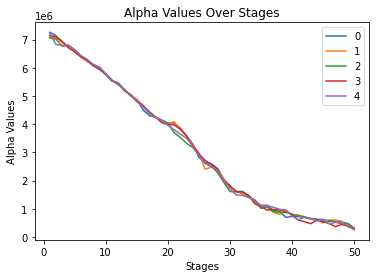

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

for s in range(len(res1_inflow)):
    alpha_values_scenario = scenario_data[s]["alpha_values"]
    x_values = range(1, len(alpha_values_scenario) + 1)  # X-axis values representing stages
    ax.plot(x_values, alpha_values_scenario, label=s)

# Set labels and title
ax.set_xlabel('Stages')
ax.set_ylabel('Alpha Values')
ax.set_title('Alpha Values Over Stages')

# Add a legend to distinguish between scenarios
ax.legend()

# Show the plot
plt.show()


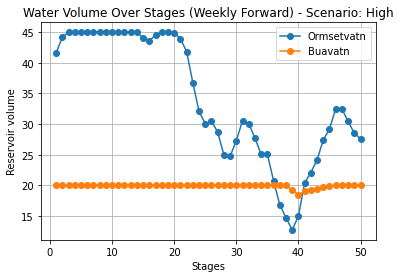

In [ ]:
# Extract the keys (stages) and values from the dictionaries
stages = list(end_volume.keys())
values1 = [item[0] for item in end_volume.values()]
values2 = [item[1] for item in end_volume.values()]

plt.plot(stages, values1, label='Ormsetvatn', marker='o', linestyle='-')
plt.plot(stages, values2, label='Buavatn', marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Stages')
plt.ylabel('Reservoir volume')
plt.title('Water Volume Over Stages (Weekly Forward) - Scenario: High')

# Add a legend to differentiate between Dual_values1 and Dual_values2
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

#Plot hourly!!!

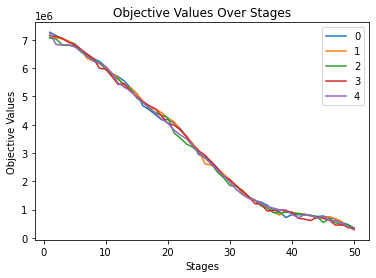

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

for s in range(len(res1_inflow)):
    objective_values_scenario = scenario_data[s]["objective_values"]
    x_values = range(1, len(objective_values_scenario) + 1)  # X-axis values representing stages
    ax.plot(x_values, objective_values_scenario, label=s)

# Set labels and title
ax.set_xlabel('Stages')
ax.set_ylabel('Objective Values')
ax.set_title('Objective Values Over Stages')

# Add a legend to distinguish between scenarios
ax.legend()

# Show the plot
plt.show()